# Setup

In [1]:
!pip install --upgrade --force-reinstall --no-deps --quiet kaggle

     |████████████████████████████████| 58 kB 6.0 MB/s 


In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle competitions download -c tensorflow-great-barrier-reef -p /content/starfish

100% 14.2G/14.2G [02:34<00:00, 121MB/s]
100% 14.2G/14.2G [02:34<00:00, 98.4MB/s]


In [11]:
!unzip /content/starfish/*.zip -d /content/starfish/

Streaming output truncated to the last 5000 lines.
  inflating: /content/starfish/train_images/video_2/4303.jpg  
  inflating: /content/starfish/train_images/video_2/4304.jpg  
  inflating: /content/starfish/train_images/video_2/4305.jpg  
  inflating: /content/starfish/train_images/video_2/4306.jpg  
  inflating: /content/starfish/train_images/video_2/4307.jpg  
  inflating: /content/starfish/train_images/video_2/4308.jpg  
  inflating: /content/starfish/train_images/video_2/4309.jpg  
  inflating: /content/starfish/train_images/video_2/431.jpg  
  inflating: /content/starfish/train_images/video_2/4310.jpg  
  inflating: /content/starfish/train_images/video_2/4311.jpg  
  inflating: /content/starfish/train_images/video_2/4312.jpg  
  inflating: /content/starfish/train_images/video_2/4313.jpg  
  inflating: /content/starfish/train_images/video_2/4314.jpg  
  inflating: /content/starfish/train_images/video_2/4315.jpg  
  inflating: /content/starfish/train_images/video_2/4316.jpg  
  inf

In [12]:
!rm /content/starfish/*.zip

# Dataset

In [13]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json

In [14]:
!ls /content/starfish

example_sample_submission.csv  greatbarrierreef  train.csv
example_test.npy	       test.csv		 train_images


In [15]:
train_df = pd.read_csv('/content/starfish/train.csv')

In [127]:
for fpath in image_filepaths:
    print(fpath)
    break

/content/starfish/train_images/video_2/9675.jpg


In [ ]:
#img_sizes = []
#c = 0
#for fpath in image_filepaths:
#    img_size = keras.preprocessing.image.load_img(fpath).size
#    img_sizes.append(img_size)
#    c += 1
#    if c % 1000 == 0:
#        print(f"{c}/{len(image_filepaths)}")

# ALL IMAGES (1280, 720) - (W, H)

In [257]:
# 
# Get image dataset
#
# Note: Class = video_id
train_images_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/content/starfish/train_images/',
    validation_split=None,
    seed=123,
    image_size=(256,256),
    batch_size=1,
    label_mode=None
)
image_filepaths = train_images_ds.file_paths
train_images_ds = train_images_ds.map(lambda x: x / 255.0)

#
# Get filename dataset
#
# Note: filepath = /content/starfish/train_images/{video_id}/{video_frame}.jpg
train_fnames_ds = tf.data.Dataset.from_tensor_slices(image_filepaths)

#
# Get annotation dataset
#
# Note: image_id = {video_id}-{video_frame}
fpaths = image_filepaths
fpaths = [fpath.split('/content/starfish/train_images/')[1] for fpath in fpaths]
image_id = [fpath.split('/')[0][-1] + '-' + fpath.split('/')[1].split('.')[0] for fpath in fpaths]
annotations_df = train_df[['image_id', 'annotations']].set_index('image_id')
annotations_df = annotations_df.loc[image_id]
annotations_df = annotations_df['annotations'].apply(lambda x: json.loads(x.replace("'", '"')))
from collections import defaultdict
def process(x):
    # Format - (xmin, ymin, width, height)
    if len(x) == 0:
        out = []
    if len(x) == 1:
        out = x[0]
        out = [list(out.values())]
    if len(x) > 1:
        out = []
        for d in x:
            out.append(list(d.values()))
    return out
def convert_abs_to_rel(abs_annotations, img_size=(1280, 720)):
    # img_size : (W, H)
    if len(abs_annotations) == 0:
        return abs_annotations
    else:
        W, H = img_size
        abs_annotations = np.array(abs_annotations) # :: (# of starfish, 4)
        scaling_factors = np.array([W, H, W, H])-1  # :: (4,)
        rel_annotations = abs_annotations / scaling_factors
        rel_annotations = rel_annotations.astype(np.float32)
        return rel_annotations

annotations_df = annotations_df.apply(process)
annotations_df = annotations_df.apply(convert_abs_to_rel)
annotation_flags = ~annotations_df.apply(lambda x: len(x) == 0)
annotations_ragged = tf.ragged.constant(annotations_df)
train_annotations_ds = tf.data.Dataset.from_tensor_slices(annotations_ragged)
train_annotation_flags_ds = tf.data.Dataset.from_tensor_slices(annotation_flags)

# 
# Get target bounds delta: 
#   - always from left to right
#   - ie. 100% = @ right edge, 0% = @ left edge
#   - Note: images provided in training set are (1280, 720)
#
def get_rightside_tar_bounds(annotations):
    if len(annotations) == 0:
        return annotations
    else:
        annotations = np.array(annotations)
        rside_tar_bounds = annotations[:, 0] + annotations[:, 2]
        return rside_tar_bounds

rside_tar_bounds = annotations_df.apply(get_rightside_tar_bounds)
rside_tar_bounds_ragged = tf.ragged.constant(rside_tar_bounds)
rside_tar_bounds_ds = tf.data.Dataset.from_tensor_slices(rside_tar_bounds_ragged)

#
# Combine datasets
#
train_ds = tf.data.Dataset.zip((train_fnames_ds, train_images_ds, train_annotations_ds, train_annotation_flags_ds, rside_tar_bounds_ds))
train_ds = train_ds.map(lambda v,w,x,y,z: {'filename': v, 'image': w, 'annotations': x.to_tensor(), 'has_annotation': y, 'rside_tar_bounds': z})

Found 23501 files belonging to 1 classes.


In [258]:
next(iter(train_ds))

{'annotations': <tf.Tensor: shape=(0, 0), dtype=float32, numpy=array([], shape=(0, 0), dtype=float32)>,
 'filename': <tf.Tensor: shape=(), dtype=string, numpy=b'/content/starfish/train_images/video_2/9675.jpg'>,
 'has_annotation': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'image': <tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
 array([[[[0.02034314, 0.36360294, 0.5133578 ],
          [0.01997549, 0.36789215, 0.49375   ],
          [0.03210784, 0.3408088 , 0.46348038],
          ...,
          [0.03884804, 0.2192402 , 0.32120097],
          [0.03137255, 0.23529412, 0.32941177],
          [0.04742647, 0.23137255, 0.33333334]],
 
         [[0.00281863, 0.42205882, 0.5726716 ],
          [0.00110294, 0.40061274, 0.5204657 ],
          [0.05269608, 0.34681374, 0.46838236],
          ...,
          [0.03419118, 0.2185049 , 0.32046568],
          [0.03529412, 0.23137255, 0.32941177],
          [0.03137255, 0.23529412, 0.32941177]],
 
         [[0.04963235, 0.54240197, 0.5942

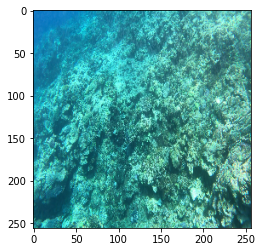

In [259]:
import matplotlib.pyplot as plt

sample = next(iter(train_ds))
plt.imshow(sample['image'][0])

# Model

In [260]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [261]:
# CNN
# In Image? or Not in Image?
# Push in side boundaries (relative %)
# Input - Image
# Output - In Image Flag? (Confidence)
# Output - % Change of respective boundary
# Loss - L2 Distance from True Boundary

In [262]:
basemodel = keras.applications.efficientnet.EfficientNetB0(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

In [269]:
class StarfishModel(keras.Model):
    def __init__(self, basemodel):
        super(StarfishModel, self).__init__()
        self.basemodel = basemodel # :: (None, None, None, 1280)
        self.globalpool2d = layers.GlobalAveragePooling2D() # :: (None, 1280)
        self.is_object_head = keras.Sequential([
            layers.Dense(1, activation='softmax')
        ])
        self.boundary_delta_head = keras.Sequential([
            layers.Dense(1, activation='softmax')
        ])

    def call(self, sample):
        image = sample['image']
        features = self.basemodel(image)
        pooled_features = self.globalpool2d(features)
        is_obj = self.is_object_head(pooled_features)
        bounds_delta = self.boundary_delta_head(pooled_features)
        return is_obj, bounds_delta

    def compile(self, optimizer):
        super(StarfishModel, self).compile()
        self.optimizer = optimizer

    @tf.function
    def train_step(self, sample):
        has_annotation = sample['has_annotation']
        is_obj_tar = tf.cast(sample['has_annotation'], tf.float32)
        bounds_delta_tar = sample['rside_tar_bounds']
        max_bounds_delta_tar = tf.reduce_max(bounds_delta_tar)
        
        with tf.GradientTape() as tape:
            is_obj, bounds_delta = self.call(sample)
            is_obj_loss = tf.losses.binary_crossentropy(is_obj, is_obj_tar)
            loss = is_obj_loss
            if has_annotation:
                bounds_delta_loss = tf.losses.mse(bounds_delta, max_bounds_delta_tar)
                loss += bounds_delta_loss
            else:
                bounds_delta_loss = tf.constant([])

        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"is_obj_loss": is_obj_loss, "bounds_delta_loss": bounds_delta_loss}

In [270]:
sample = next(iter(train_ds))

In [271]:
model = StarfishModel(basemodel)
model.compile(keras.optimizers.Adam())

In [272]:
model(sample)

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>)

In [273]:
model.train_step(sample)

{'bounds_delta_loss': <tf.Tensor: shape=(0,), dtype=float32, numpy=array([], dtype=float32)>,
 'is_obj_loss': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([15.424949], dtype=float32)>}

### Train "Is Object" Head First

In [276]:
model.boundary_delta_head.trainable = False

In [279]:
is_obj_train_ds = train_ds.map(lambda x: x['image'][0]).batch(32)

In [ ]:
model.boundary_delta_head.trainable = True